# Using `ddipp` with `fastai v1` Notebooks
## Introduction

`ddipp` is a collection of line and cell magics for iPython and Jupyter notebook.  It uses `ipyparallel` to manage PyTorch's Distributed Data Parallel (DDP) process group as a cluster.  In this aspect, `ddipp` is like a traffic controller, it directs the execution of cells between the local process (the interactive notebook), and the remote DDP process group, and streams/display the outputs.

`ddipp` treats `fastai` as a client application that uses the PyTorch DDP (currently  `fastai_v1` is the default application).  `ddipp` is designed to minimize changes to  existing `fastai` Jupyter notebooks, and without requiring any change to the fastai codebase itself.


Let's try it on a barebone version of the `fastai` lesson3-CamVid notebook.

## Image segmentation with CamVid

**Load extension with `%load_ext ddipp`, and create DDP group.**

Creating the DDP group now, so that `fastai` libraries can be imported to both local and DDP process namespace in one go, without repeating the step later.  See the next cell.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%load_ext ippddp.ddipp
%makedip -g all -a fastai_v1

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-ippdpp_c-client.json


Connecting to ipyparallel cluster.......

Initializing torch distributed group with GPUs [0, 1, 2]
Local Ranks initialized:  ['GPU0=0', 'GPU1=1', 'GPU2=2']
Importing on cluster: ['import fastai, fastai.torch_core, torch, fastprogress', 'from fastai.distributed import *', 'from ippddp.ddipp.fastai_v1 import initializer, finalizer, set_verbose, lr_find_bypass']
fastai_v1:
[Process 25946] Rank 0 fastai initialized for distributed data parallel.
[Process 25950] Rank 1 fastai initialized for distributed data parallel.
[Process 25952] Rank 2 fastai initialized for distributed data parallel.


**Load python libraries needed for data exploration, and later for training**

In [2]:
%%dip everywhere
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

%%dip everywhere: Running cell in local namespace.
%%dip everywhere: Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


**Explore the raw data locally in notebook process**

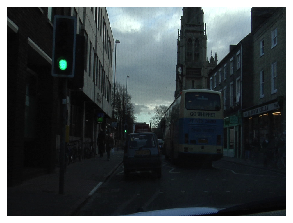

In [3]:
path = untar_data(URLs.CAMVID)
path_lbl = path/'labels'
path_img = path/'images'
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

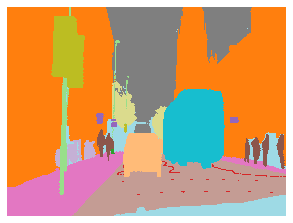

In [4]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

... Perform data cleaning, pre-training augmentation or transformation as necessary in this local notebook process, till about time to create the *training dataset*

In [5]:
src_size = np.array(mask.shape[1:])
codes = np.loadtxt(path/'codes.txt', dtype=str)
size = src_size//2
bs=8
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

**Create training dataset on remote DDP processes**

In order to create training dataset on all DDP processes (one per GPU) using `fastai` (e.g. the `databunch` api etc), let's send all the necessary ingridients -- variables and objects prepared above -- to the DDP side first, using **%dipush var1 var2 ... varN**.

Then we can start cooking, turn on the stove with **%autodip on**

In [6]:
%dipush bs size get_transforms src src_size path path_lbl path_img codes get_y_fn
%autodip on

Pushing parameters to DDP namespace: ['bs', 'size', 'get_transforms', 'src', 'src_size', 'path', 'path_lbl', 'path_img', 'codes', 'get_y_fn']
Auto Execution on DDP group: on, will run cell as %%dip


**With `%autodip` set to `on`, all cells below will be executed on the DDP processes, not the local notebook namespace.  The exception is when the cell starts with any `%` or `%%` line/cell magic**

Objects and variables created in these cells are not visible in the local notebook, unless
they are explicitly pulled.

For example, below, with `%dipull name2vid` as the first line of the cell.

1. the cell will be executed locally
2. `name2vid` will be pulled into the local notebook namespace.

In [16]:
%%dip --see all
name2id = {v:k for k,v in enumerate(codes)}
name2id['Void']

%%dip --see all: Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:9]: 30

Out[1:9]: 30

Out[2:9]: 30

In [14]:
%dipull name2id
import os
print(f"Local Process {os.getpid()} name2id void code: {name2id['Void']}")

Pulling from DDP namespace: ['name2id']
Local Process 25892 name2id void code: 30


%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
Proc [25946] Rank [0] Removing callback <class 'fastai.distributed.DistributedTrainer'> from learner.
Proc [25946] Rank [0] Removing callback <class 'fastai.distributed.DistributedRecorder'> from learner.
Proc [25946] Rank [0] Running lr_find() in non DDP mode
epoch     train_loss  valid_loss  acc_camvid  time    
0         856.610413  #na#        00:45       ████---| 93.33% [70/75 00:44<00:03 3.0819]
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


[output:0]

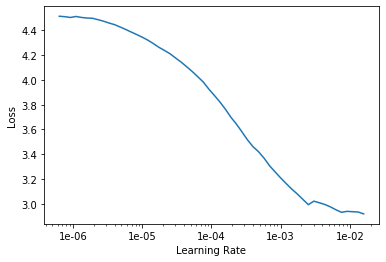

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics=acc_camvid
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
# lr_find(learn)
learn.lr_find()
learn.recorder.plot()

In [18]:
lr=3e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
epoch     train_loss  valid_loss  acc_camvid  time    
0         2.034538    1.392599    0.669675    00:30                                       
1         1.471321    0.794334    0.805304    00:20                                       
2         1.145706    0.656235    0.835971    00:20                                       
3         0.932728    0.570271    0.846980    00:20                                       
4         1.375380    1.862201    0.400517    00:20                                       
5         1.534345    1.501809    0.623359    00:20                                       
6         1.589562    1.408101    0.649184    00:20                                       
7         1.492622    1.327942    0.673429    00:20                                       
8         1.362964    1.274983    0.633576    00:20                                       
9         1.264217    1.067748    0.711274    00:20           

## Speedup observed

   Notebook       [3-GPUs timing]  [Single-GPU timing]          LOC
* lesson3-CamVid: [3:30,4:24,12:00,12:52] [7:33,9:12,31:50,33:40]    6
* lesson3-planet: [3:20,3:45,6:15,7:30]   [4:20,5:35,14:35,18:30]    4
* lesson4-collab: Training time too short
* lesson4-tabular: Training time too short, but conversion is simple, only 1 cell, 3 lines.
* lesson5-sgd-mnist: Training time too short
* lesson6-pets-more: [1:06, 0:48,1:30,]      [1:09, 0:48, 1:30]
* lesson6-rossmann: [1:45,1:45,1:45]        [3:00,      4]

